# Exploratory Data Analysis
This notebook aims to study the data on a deeper level for the following reasons:

Currently, we are averaging speed across **ALL vehicles** by **hour**. 
Census regions are broad - contain multiple routes and vehicle types that drive through over a given month. 

The data is the time series speed data of **all vehicle types** belonging to a specific **region** for a given month
- Do speeds vary significantly by vehicle type?
    - We see that certain vehicles have consistent speed readings over the duration of the month - drive through only once? 
- What do the 0 readings mean?  S(i.e., vehicle pausing, parking, etc) 
- What is the **rule** for recording speeds? (Change in speed? distance? time?) - some vehicles only appear once in a months span for a region 
- The time of recording is inconsistent. No real pattern as time jumps from minute, 2 min, to hour. 

In [130]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
import re
import sys

In [131]:
input_dir = '../../raw_data/'

data_files = os.listdir(input_dir)
for i, j in enumerate(data_files):
    print(i, j)        

0 Speed Limits.zip
1 google_transit.zip
2 streets.json
3 speed_limits
4 revenue_equipment_list.csv
5 google_transit
6 sf_speed_data
7 TransportationTerminology.pdf
8 speed_limit_sf.json
9 census_zones


In [132]:
vehicle_types = pd.read_csv(input_dir + data_files[4], usecols=[0,1])
print("Size of df: {}".format(vehicle_types.shape))
print("Number of unqiue v-types: {}".format(vehicle_types["EQUIP_NAME"].nunique()))
vehicle_types.head()

Size of df: (1689, 2)
Number of unqiue v-types: 65


,EQUIP_CODE,EQUIP_NAME
0,4658,40' FLYER COACH
1,4662,40' FLYER COACH
2,7053,ARTICULATED FLYER
3,1548,LRV3-MOD11
4,17,POWELL STREET CAR


In [133]:
input_dir = '../../temp_data/region_data/'
print('Number of region files: {}'.format(len(os.listdir(input_dir))))
files = os.listdir(input_dir)

Number of region files: 196


In [135]:
sample_df = pd.read_csv(input_dir + files[50])
print("Size of df: {}".format(sample_df.shape))
sample_df.head()

Size of df: (190509, 9)


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10
0,1513,2016-02-01 16:02:50,6203,-122.404854,37.731320,2.778,POINT (-122.404854 37.73132),68,6075025702
1,1513,2016-02-01 16:04:20,6203,-122.404800,37.730373,3.333,POINT (-122.4048 37.730373),68,6075025702
2,1513,2016-02-01 16:24:25,6203,-122.401910,37.726288,19.167,POINT (-122.40191 37.726288),68,6075025702
3,1513,2016-02-01 17:36:24,6203,-122.404480,37.729687,3.889,POINT (-122.40448 37.729687),68,6075025702
4,1513,2016-02-01 18:55:47,6203,-122.404720,37.730140,0.000,POINT (-122.40472 37.73014000000001),68,6075025702


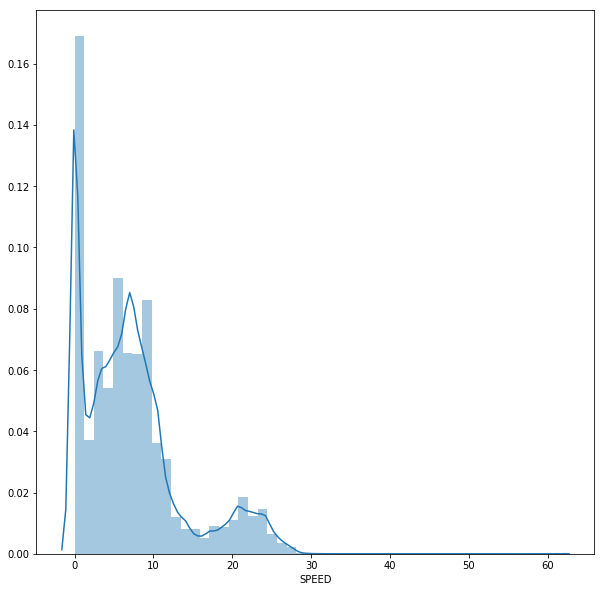

In [136]:
# All vehicle types
plt.figure(figsize=(10,10))
g = sns.distplot(sample_df['SPEED'])

In [137]:
sample_df_vehicle_type = sample_df.join(how='left', lsuffix='VEHICLE_TAG', rsuffix='EQUIP_CODE', other=vehicle_types)
print("Size of df: {}".format(sample_df_vehicle_type.shape))
sample_df_vehicle_type.head()

Size of df: (190509, 11)


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10,EQUIP_CODE,EQUIP_NAME
0,1513,2016-02-01 16:02:50,6203,-122.404854,37.731320,2.778,POINT (-122.404854 37.73132),68,6075025702,4658,40' FLYER COACH
1,1513,2016-02-01 16:04:20,6203,-122.404800,37.730373,3.333,POINT (-122.4048 37.730373),68,6075025702,4662,40' FLYER COACH
2,1513,2016-02-01 16:24:25,6203,-122.401910,37.726288,19.167,POINT (-122.40191 37.726288),68,6075025702,7053,ARTICULATED FLYER
3,1513,2016-02-01 17:36:24,6203,-122.404480,37.729687,3.889,POINT (-122.40448 37.729687),68,6075025702,1548,LRV3-MOD11
4,1513,2016-02-01 18:55:47,6203,-122.404720,37.730140,0.000,POINT (-122.40472 37.73014000000001),68,6075025702,17,POWELL STREET CAR


In [138]:
sample_df_vehicle_type["EQUIP_NAME"].unique()

array(["40' FLYER COACH", 'ARTICULATED FLYER', 'LRV3-MOD11',
       'POWELL STREET CAR', "ETI 40' STANDARD", "40' NEOPLAN",
       'LRV2-MOD9', 'BREDA MOD 11', 'CALIFORNIA LINE CAR',
       "60' NEOPLAN ARTIC", 'ETI STANDARD TROLLEY', 'ETI STANDARD TROLLY',
       'BLACKPOOL BOAT TRAM', 'SYDNEY CAR #0496', 'PRES.CONFERENCE CAR',
       'NEW ORLEANS CAR', 'PCC', 'ELECTRIC TROLLEY', 'NEW FLYER',
       'PCC-BROOKVILLE RETROFIT', 'NPCC', 'NN', 'MILAN', 'MUNI. CAR #1',
       'BREDA MOD 11 - BREDA RETROFIT', 'MUNI.CAR #130', 'LRV2-MOD 11',
       'COMBINED WITH 1435A', 'ALLISON', 'SAN FRANCISCO CAR',
       'LRV2-MOD9. MOD11', "ETI 60' ARTIC", 'NOEPLAN (CNG)',
       'LRV3-MOD11 - EBALD', 'LRVHUB1465', 'LRVHUB1482',
       'BREDA TRAILER TRUCK', 'LRVHUB1423', 'LRVHUB1431',
       'MASTER CONTROLLER', 'LRVHUB1440', 'BRUSSELS',
       "ORION VII 40' HYBRID", "ORION VII 30' HYBRID", 'LRVHUB1422',
       'BREDA MOTOR TRUCK', 'LRVHUB1479', 'LRVHUB1543', 'LRVHUB1423B',
       'M&MTB PRESTON WORK

In [139]:
# Total number of unique vehicles
sample_df_vehicle_type["EQUIP_NAME"].nunique()

65

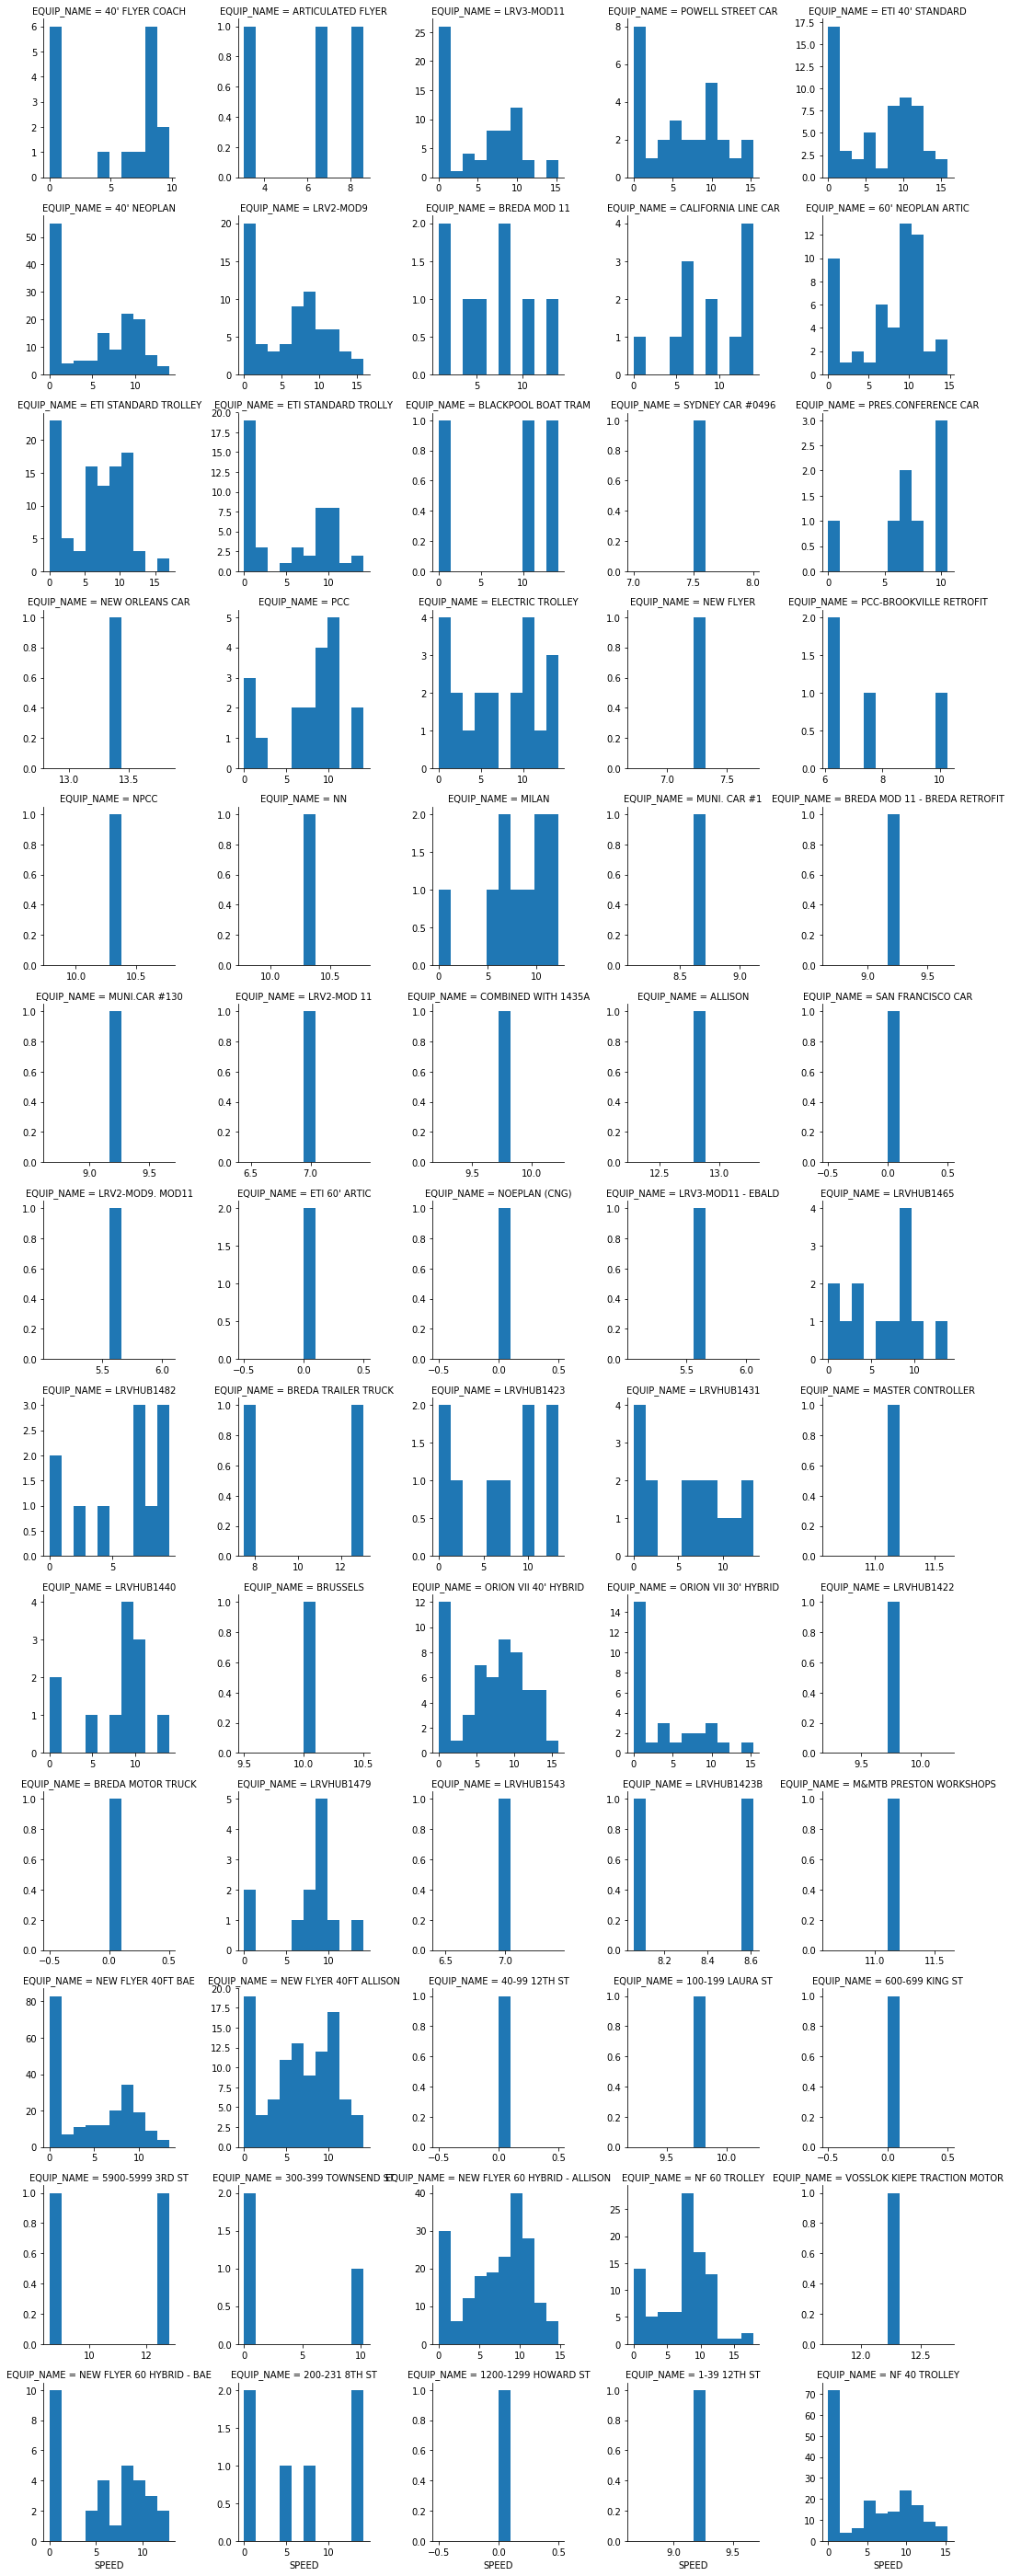

In [65]:
# # 6075047801 - index 0
# g = sns.FacetGrid(sample_df_vehicle_type, col="EQUIP_NAME", col_wrap=5, sharey=False, sharex=False)
# g = g.map(plt.hist, "SPEED")
# g.savefig('../../output/region6075047801.png')

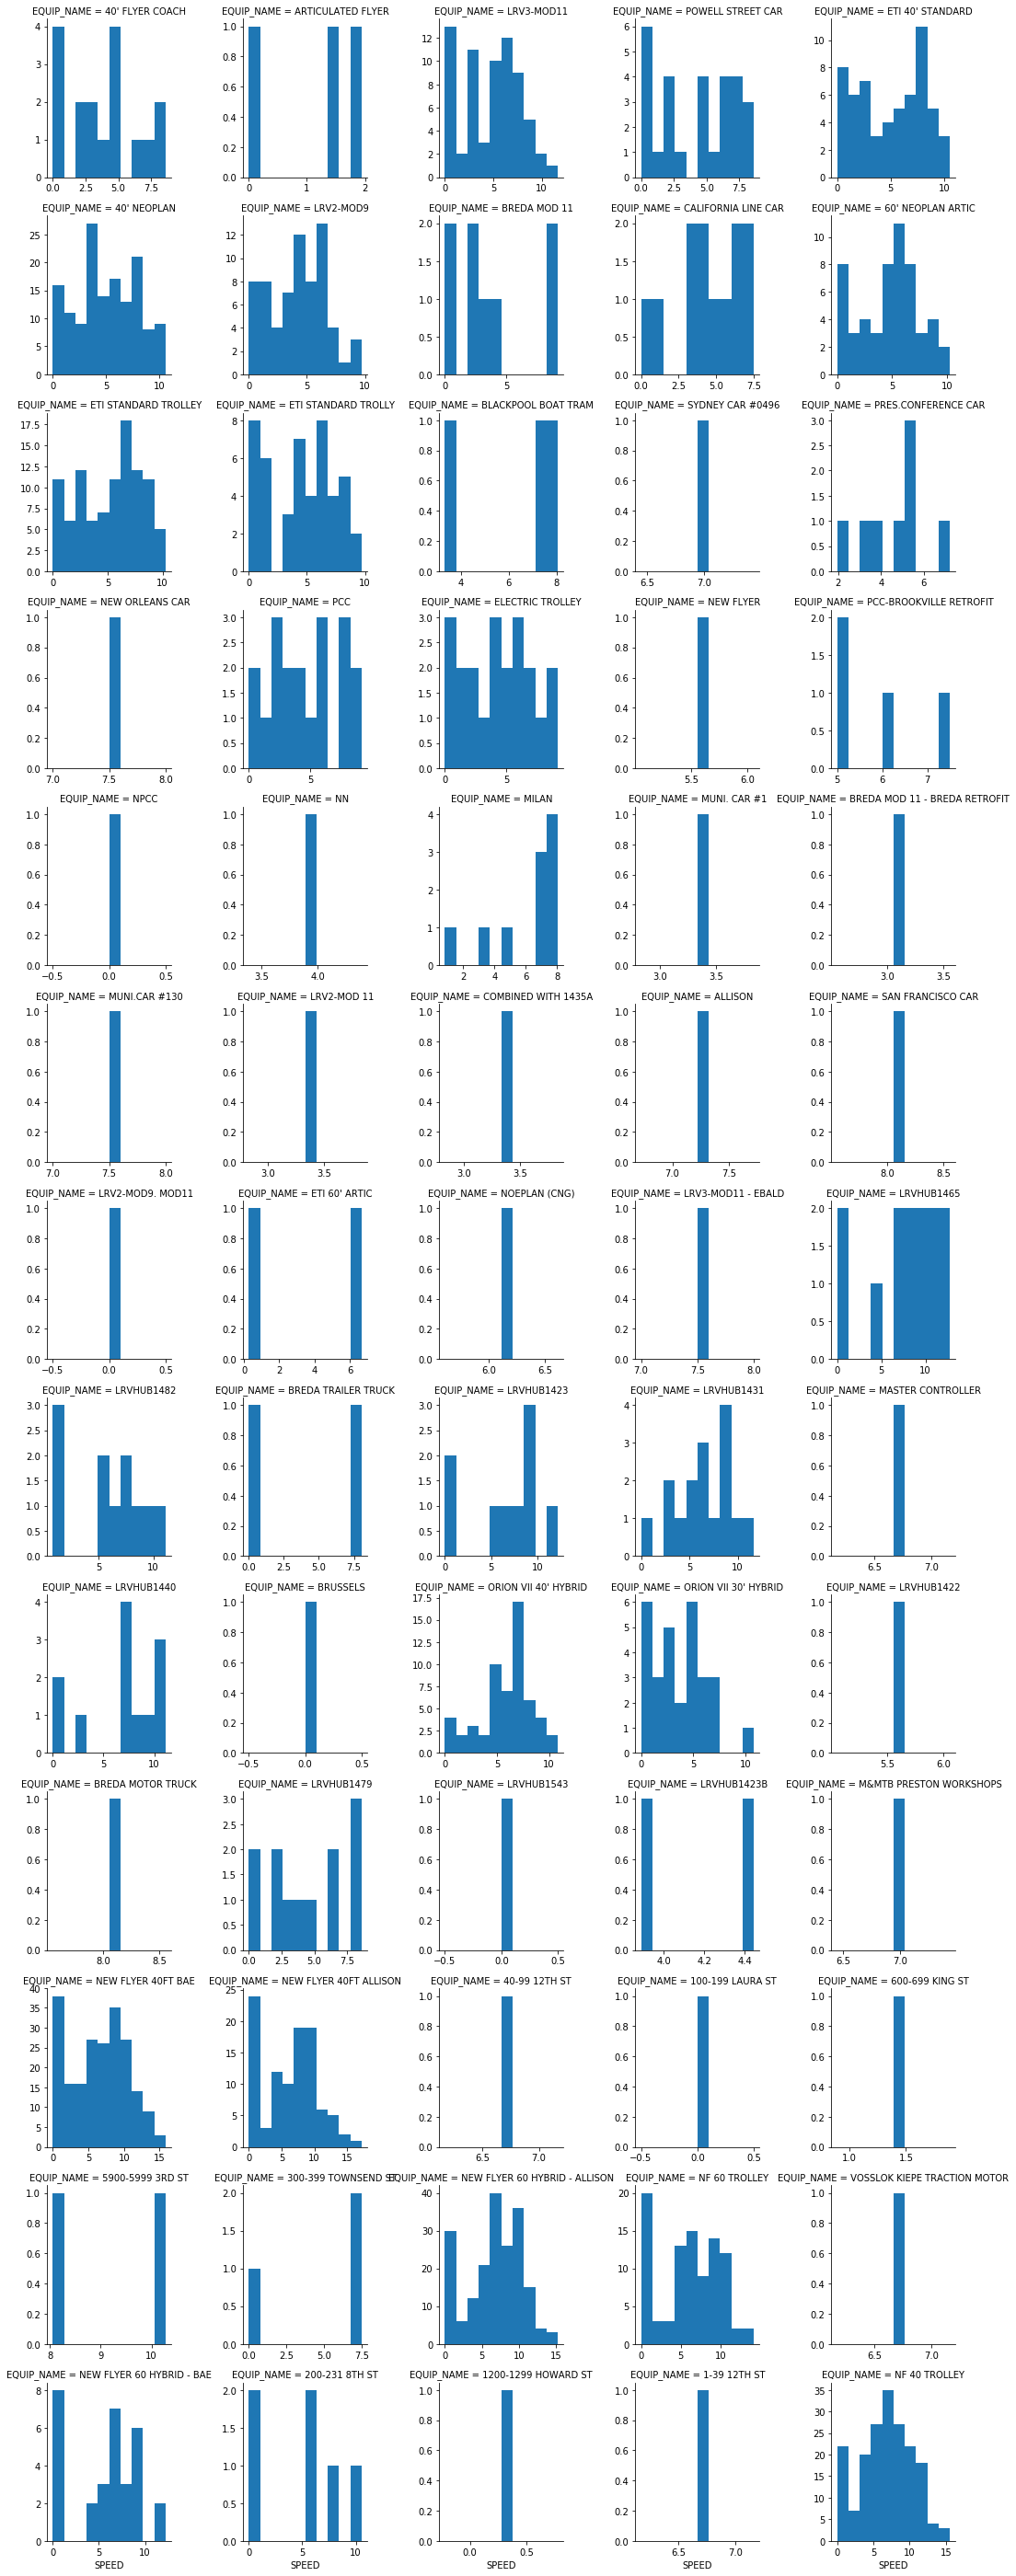

In [129]:
# 6075012800 - index 1 
g2 = sns.FacetGrid(sample_df_vehicle_type, col="EQUIP_NAME", col_wrap=5, sharey=False, sharex=False)
g2 = g2.map(plt.hist, "SPEED")
g2.savefig('../../output/region6075012800.png')

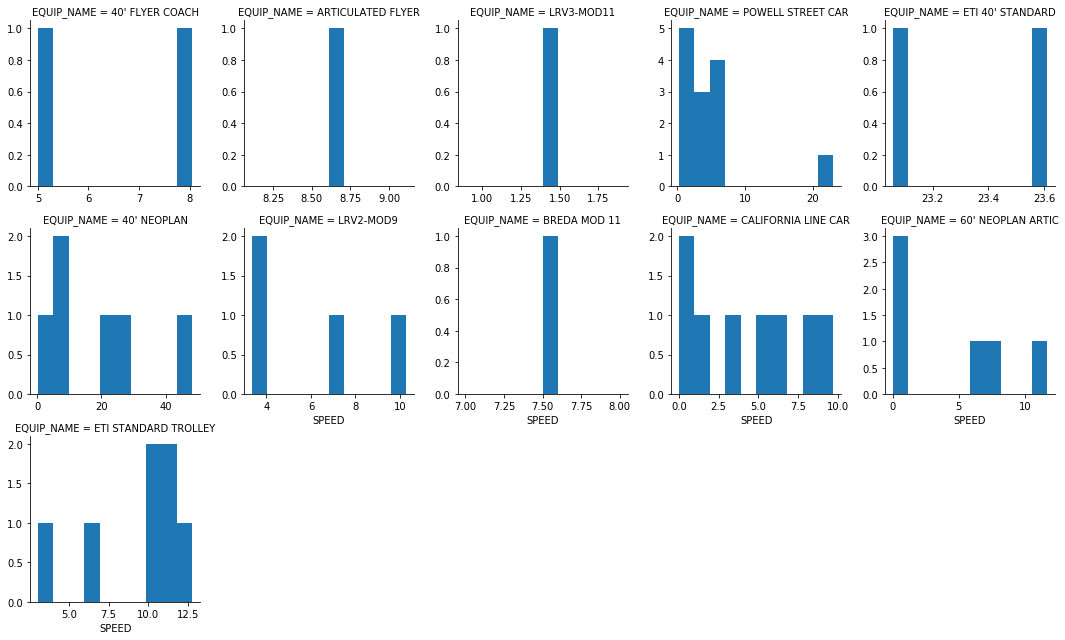

In [123]:
# # 6075990100 - index 34
# g3 = sns.FacetGrid(sample_df_vehicle_type, col="EQUIP_NAME", col_wrap=5, sharey=False, sharex=False)
# g3 = g3.map(plt.hist, "SPEED")
# g3.savefig('../../output/region6075990100.png')

In [27]:
sample_df_vehicle_type[sample_df_vehicle_type["EQUIP_NAME"] == "VOSSLOK KIEPE TRACTION MOTOR"]

,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10,EQUIP_CODE,EQUIP_NAME
1058,1513,2016-02-01 13:53:49,8419,-122.49309,37.77663,12.222,POINT (-122.49309 37.77663),53,6075047801,TM100779094,VOSSLOK KIEPE TRACTION MOTOR
